In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.applications import ResNet50
from sklearn.model_selection import train_test_split
import os

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np

yes_images = os.listdir('/content/drive/My Drive/brain_tumor_dataset/yes_aug')
no_images = os.listdir('/content/drive/My Drive/brain_tumor_dataset/no_aug')
data = np.concatenate([yes_images, no_images])
len(data) == len(yes_images) + len(no_images)

True

In [ ]:
target_pos = np.full(len(yes_images), 1)
target_neg = np.full(len(no_images), 0)
target_data = np.concatenate([target_pos, target_neg])
len(target_data)==len(target_pos) + len(target_neg)

True

In [ ]:
import cv2

split_data = []
with tf.device('/device:GPU:0'):
  for image in yes_images:
    img = cv2.imread('/content/drive/My Drive/brain_tumor_dataset/yes_aug/' + image)
    face = cv2.resize(img, (256, 256))
    (b, g, r)=cv2.split(face) 
    img=cv2.merge([r,g,b])
    split_data.append(face)
    
  for image in no_images:
    img = cv2.imread('/content/drive/My Drive/brain_tumor_dataset/no_aug/' + image)
    face = cv2.resize(img, (256, 256))
    (b, g, r)=cv2.split(face) 
    img=cv2.merge([r,g,b])
    split_data.append(face)

In [ ]:
d = np.squeeze(split_data)
d.shape

# normalize data
d = d.astype('float32')
d /= 255

In [ ]:
from sklearn.utils import shuffle

d, target_data = shuffle(d, target_data)

In [ ]:
def split_data(X, y, test_size=0.2):

    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
from sklearn.model_selection import train_test_split

# X_train, y_train, X_val, y_val, X_test, y_test = split_data(d, target_data, test_size=0.4)

X_train, X_test, y_train, y_test = train_test_split(d, target_data, test_size=0.3,random_state=109) # 70% training and 30% test

In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
import keras

model_resnet = ResNet50(include_top = False, weights = 'imagenet', input_shape = (256, 256, 3))

output = model_resnet.layers[-1].output
output = keras.layers.Flatten()(output)

model_resnet = Model(model_resnet.input, output = output)

for layer in model_resnet.layers:
  layer.trainable = False

model_resnet.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("fl...)`
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()

model.add(model_resnet)
model.add(Dense(64, activation='relu', input_dim=(256, 256, 3)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 131072)            23587712  
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8388672   
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 31,978,497
Trainable params: 8,390,785
Non-trainable params: 23,587,712
__________________________________

In [ ]:
with tf.device('/device:GPU:0'):
  history = model.fit(X_train, y_train,
                              epochs=5,
                              validation_data=(X_test, y_test))

Train on 1207 samples, validate on 518 samples
Epoch 1/5
1207/1207 [==============================] - 13s 11ms/step - loss: 2.0429 - accuracy: 0.6951 - val_loss: 0.8949 - val_accuracy: 0.4826
Epoch 2/5
1207/1207 [==============================] - 11s 9ms/step - loss: 0.6538 - accuracy: 0.7622 - val_loss: 0.7512 - val_accuracy: 0.4479
Epoch 3/5
1207/1207 [==============================] - 11s 9ms/step - loss: 0.4442 - accuracy: 0.8028 - val_loss: 0.9996 - val_accuracy: 0.4826
Epoch 4/5
1207/1207 [==============================] - 11s 9ms/step - loss: 0.4459 - accuracy: 0.8525 - val_loss: 1.3726 - val_accuracy: 0.4826
Epoch 5/5
1207/1207 [==============================] - 11s 9ms/step - loss: 0.3572 - accuracy: 0.8401 - val_loss: 1.3106 - val_accuracy: 0.4826


In [ ]:
# model.save(‘history_resnet50.h5’)

In [ ]:
model_resnet.trainable = True
set_trainable = False
for layer in model_resnet.layers:
    if layer.name in ['res5c_branch2b', 'res5c_branch2c', 'activation_97']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
layers = [(layer, layer.name, layer.trainable) for layer in model_resnet.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])



,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_2,False
1,<keras.layers.convolutional.ZeroPadding2D obje...,conv1_pad,False
2,<keras.layers.convolutional.Conv2D object at 0...,conv1,False
3,<keras.layers.normalization.BatchNormalization...,bn_conv1,False
4,<keras.layers.core.Activation object at 0x7f62...,activation_50,False
...,...,...,...
171,<keras.layers.convolutional.Conv2D object at 0...,res5c_branch2c,True
172,<keras.layers.normalization.BatchNormalization...,bn5c_branch2c,True
173,<keras.layers.merge.Add object at 0x7f5eb4bcef28>,add_32,True
174,<keras.layers.core.Activation object at 0x7f5e...,activation_98,True


In [47]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
from keras import regularizers
from keras.optimizers import Adam

model_finetuned = Sequential()
model_finetuned.add(model_resnet)
model_finetuned.add(Dense(512, activation='relu', input_dim=(256, 256, 3)))
model_finetuned.add(Dropout(0.5))
model_finetuned.add(Dense(512, activation='relu'))
model_finetuned.add(Dropout(0.5))
model_finetuned.add(Dense(1, activation='sigmoid'))

# opt = Adam(0.001)
model_finetuned.compile(loss='binary_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])
model_finetuned.summary()



Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 131072)            23587712  
_________________________________________________________________
dense_22 (Dense)             (None, 512)               67109376  
_________________________________________________________________
dropout_15 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_16 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 513       
Total params: 90,960,257
Trainable params: 70,788,097
Non-trainable params: 20,172,160
_________________________________

In [48]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history_1 = model_finetuned.fit(X_train, y_train,
                                  epochs=20,
                                  validation_data=(X_test, y_test))

Train on 1207 samples, validate on 518 samples
Epoch 1/20
1207/1207 [==============================] - 15s 13ms/step - loss: 0.4758 - accuracy: 0.9677 - val_loss: 21.3059 - val_accuracy: 0.4826
Epoch 2/20
1207/1207 [==============================] - 13s 11ms/step - loss: 0.9722 - accuracy: 0.9917 - val_loss: 24.2537 - val_accuracy: 0.4826
Epoch 3/20
1207/1207 [==============================] - 13s 11ms/step - loss: 0.5134 - accuracy: 0.9934 - val_loss: 2.1196 - val_accuracy: 0.5347
Epoch 4/20
1207/1207 [==============================] - 13s 11ms/step - loss: 0.9047 - accuracy: 0.9892 - val_loss: 18.6526 - val_accuracy: 0.4826
Epoch 5/20
1207/1207 [==============================] - 13s 11ms/step - loss: 1.2081 - accuracy: 0.9909 - val_loss: 8.5606 - val_accuracy: 0.4788
Epoch 6/20
1207/1207 [==============================] - 13s 11ms/step - loss: 0.2994 - accuracy: 0.9967 - val_loss: 30.0027 - val_accuracy: 0.4826
Epoch 7/20
1207/1207 [==============================] - 13s 11ms/step - l

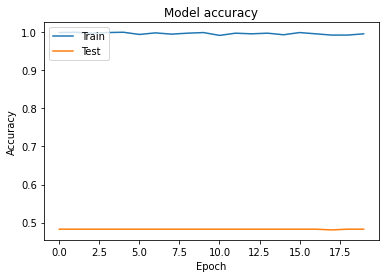

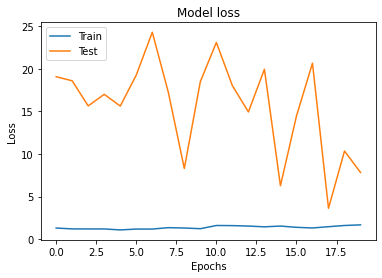

In [46]:
%matplotlib inline
from matplotlib import pyplot as plt

# Plot training & validation accuracy values
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

......................................... EARLIER VERSION BELOW ......................................

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
from keras import regularizers
from keras.optimizers import Adam
# kernel_regularizer=regularizers.l2(0.001)
model_finetuned1024 = Sequential()
model_finetuned1024.add(model_resnet)
model_finetuned1024.add(Dense(1024, activation='relu', input_dim=(256, 256, 3)))
model_finetuned1024.add(Dropout(0.5))
model_finetuned1024.add(Dense(1024,kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model_finetuned1024.add(Dropout(0.5))
model_finetuned1024.add(Dense(1, activation='sigmoid'))

# opt = Adam(0.001)
model_finetuned1024.compile(loss='binary_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])
model_finetuned1024.summary()



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 131072)            23587712  
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              134218752 
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 1025      
Total params: 158,857,089
Trainable params: 138,684,929
Non-trainable params: 20,172,160
_______________________________

In [ ]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history_2 = model_finetuned1024.fit(X_train, y_train,
                                  epochs=20,
                                  validation_data=(X_test, y_test))

Train on 1207 samples, validate on 518 samples
Epoch 1/20
 544/1207 [============>.................] - ETA: 8s - loss: 1.6062 - accuracy: 0.9522

KeyboardInterrupt: ignored

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

# Plot training & validation accuracy values
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
from keras import regularizers
from keras.optimizers import Adam

model_finetuned2048 = Sequential()
model_finetuned2048.add(model_resnet)
model_finetuned2048.add(Dense(2048,kernel_regularizer=regularizers.l2(0.001), activation='relu', input_dim=(256, 256, 3)))
model_finetuned2048.add(Dropout(0.5))
model_finetuned2048.add(Dense(2048,kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model_finetuned2048.add(Dropout(0.5))
model_finetuned2048.add(Dense(1, activation='sigmoid'))

# opt = Adam(0.001)
model_finetuned2048.compile(loss='binary_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])
model_finetuned2048.summary()



In [ ]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history_3 = model_finetuned2048.fit(X_train, y_train,
                                  epochs=20,
                                  validation_data=(X_test, y_test))

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

# Plot training & validation accuracy values
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


.......................DO NOT MESS WITH THE CODE BELOW............................

In [ ]:
model_1 = Sequential()
model_1.add(ResNet50(include_top=False, pooling='max', weights="imagenet"))
model_1.add(Dense(units = 512, activation = 'sigmoid'))
model_1.add(Dropout(0.5))
model_1.add(Dense(units = 512, activation = 'sigmoid'))
model_1.add(Dropout(0.5))
model_1.add(Dense(units = 1, activation = 'sigmoid'))
model_1.layers[0].trainable = False

In [ ]:
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from keras_applications.resnet import ResNet50

In [ ]:
import tensorflow as tf
# import tf.keras.applications.resnet.preprocess_input

In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [ ]:
model1 = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
y = model1.output
y = Flatten()(y)
y = Dropout(0.5)(y)
y = Dense(1, activation='sigmoid')(y)
model1.layers[0].trainable = False


In [ ]:
with tf.device('/device:GPU:0'):
  history_model1 = model_1.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=20)

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

# Plot training & validation accuracy values
plt.plot(history_model1.history['accuracy'])
plt.plot(history_model1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_model1.history['loss'])
plt.plot(history_model1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()